# Twitter Data Scraping and Analysis

### Twitter Data Scraping

In [1]:
import tweepy
import os
import pandas as pd

In [2]:
client = tweepy.Client(bearer_token=os.getenv("BEARER_TOKEN"), wait_on_rate_limit=True)
query = "#RealMadrid -is:retweet lang:en"
tweets = client.search_recent_tweets(query, max_results=100)

In [3]:
df = pd.DataFrame([[tweet.id, tweet.text, ','.join([str(tweet_id) for tweet_id in tweet.edit_history_tweet_ids])] for tweet in tweets.data], columns=['id', 'text', 'edit_history_tweet_ids'])
df.to_csv('tweets.csv', index=False, encoding='utf-8')

### Data Analysis

#### Tokenization

In [4]:
tweets_df = pd.read_csv('tweets.csv')
tweets_df.head()

,id,text,edit_history_tweet_ids
0,1873018051513471371,"@FabrizioRomano So, basically these were #Real...",1873018051513471371
1,1873013644046549417,Moments when players signed their shirts that ...,1873013644046549417
2,1873013537817436210,🏴󠁧󠁢󠁥󠁮󠁧󠁿🇪🇸 #TrentAlexanderArnold won’t extend w...,1873013537817436210
3,1873012361998499906,Official Announcement: Sergio Scariolo's mothe...,1873012361998499906
4,1873009570601419077,No club in the WORLD has more followers on Ins...,1873009570601419077


In [5]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer(preserve_case=False)
tokens_all = []
for tweet in tweets_df['text']:
    tokens = tweet_tokenizer.tokenize(tweet)
    tokens_all.extend(tokens)

#### Term Frequencies

In [6]:
from collections import Counter

text_freq = Counter(tokens_all)
text_freq.most_common(5)

[('#realmadrid', 100), ('the', 74), ('.', 74), (',', 64), ('to', 55)]

In [7]:
from nltk.corpus import stopwords
import string

stopwords = stopwords.words('english') + list(string.punctuation) + ['’', '“', '”', '…', '—', '–', '‘', '•', '``', "''", '``', '...', '``', '’', chr(65039), '..']
tokens_filtered = [word for word in tokens_all if word.lower() not in stopwords]

text_freq_filtered = Counter(tokens_filtered)
text_freq_filtered.most_common(5)

[('#realmadrid', 100),
 ('real', 46),
 ('madrid', 44),
 ('trent', 20),
 ('#liverpool', 18)]

In [8]:
hashtag_freq = Counter([word for word in tokens_filtered if word.startswith('#')])
print(f"Hashtag Frequencies: {hashtag_freq.most_common(5)}")

word_freq = Counter([word for word in tokens_filtered if not word.startswith(("#", "@"))])
print(f"Word Frequencies: {word_freq.most_common(5)}")

Hashtag Frequencies: [('#realmadrid', 100), ('#liverpool', 18), ('#football', 13), ('#lfc', 9), ('#trentalexanderarnold', 7)]
Word Frequencies: [('real', 46), ('madrid', 44), ('trent', 20), ('best', 18), ('alexander-arnold', 16)]


#### Bigram Frequencies

In [9]:
from nltk import bigrams

term_bigram = bigrams(tokens_filtered)
Counter(term_bigram).most_common(5)

[(('real', 'madrid'), 42),
 (('globe', 'soccer'), 14),
 (('trent', 'alexander-arnold'), 13),
 (('soccer', 'awards'), 8),
 (('#liverpool', '#realmadrid'), 7)]

#### Term Co-occurence

In [10]:
unique_words = sorted(list(set(word for word in tokens_filtered if not word.startswith(('@', "#")))))
correlation_matrix = pd.DataFrame(index=unique_words, columns=unique_words)
correlation_matrix.fillna(0, inplace=True)

for i in range(len(unique_words)):
    for j in range(0, i+1):
        word1, word2 = unique_words[i], unique_words[j]
        if word1 != word2:
            correlation_matrix.loc[word1, word2] = correlation_matrix.loc[word2, word1] = sum(1 for tweet in tweets_df['text'] if word1 in tweet_tokenizer.tokenize(tweet) and word2 in tweet_tokenizer.tokenize(tweet))

C:\Users\Joshua\AppData\Local\Temp\ipykernel_22112\247675776.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_matrix.fillna(0, inplace=True)


In [11]:
correlation_freq = []

for i in range(1, len(unique_words)):
    for j in range(0, i):
        word1, word2 = unique_words[i], unique_words[j]
        correlation_freq.append((word1, word2, int(correlation_matrix.loc[word1, word2])))

correlation_freq.sort(key=lambda x: x[2], reverse=True)
correlation_freq[:5]

[('real', 'madrid', 37),
 ('trent', 'madrid', 14),
 ('trent', 'real', 13),
 ('madrid', 'alexander-arnold', 12),
 ('madrid', 'liverpool', 12)]

#### Wordcloud

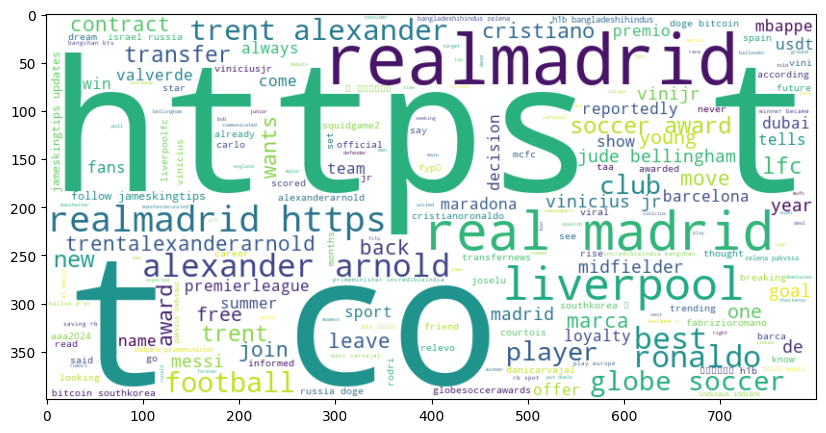

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens_filtered))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')